In [1]:
# Dowload de bibliotecas
!pip -q install gdown imbalanced-learn fastapi uvicorn nest-asyncio xgboost lightgbm

# Instalação de bibliotecas
import sys
from pathlib import Path
import importlib
import os
import zipfile
import gdown
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from time import perf_counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# enibe os warnings
import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names"
)


# caminho até a pasta
NOTEBOOK_FILE = Path(__vsc_ipynb_file__).resolve()

NOTEBOOKS_PATH = NOTEBOOK_FILE.parent          # notebooks
SEMANA_PATH    = NOTEBOOKS_PATH.parent         # semana
SCRIPTS_PATH   = SEMANA_PATH / "scripts"       # scripts
OUTPUTS_PATH   = SEMANA_PATH / "outputs"       # outputs
PROJECT_PATH   = SEMANA_PATH.parent            # projeto

sys.path.insert(0, str(SCRIPTS_PATH))

# Import do script com as funções da equipe
import flight_delay_pipeline as scr
importlib.reload(scr)

<module 'flight_delay_pipeline' from 'C:\\Users\\helen\\OneDrive\\Área de Trabalho\\OnFlight\\Projeto OnFlight\\Hackaton\\Hackaton\\data_science\\semana_03\\scripts\\flight_delay_pipeline.py'>

In [2]:
# Carregar Dados
file_id = "1207psedBKvnS0pJkDITroSzPiWrcz0ag"

# Nome do arquivo que será baixado no Colab
zip_path = "dados_vra.zip"

# Se ainda não existir o zip, baixa do Drive
if not os.path.exists(zip_path):
    url = f"https://drive.google.com/uc?id={file_id}"
    print("Baixando arquivo do Drive...")
    gdown.download(url, zip_path, quiet=False)
else:
    print("Arquivo ZIP já existe, download interrompido.")

# Extrair o conteúdo do zip
extract_folder = "dados_vra"

if not os.path.exists(extract_folder):
    print("Extraindo arquivos do ZIP...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_folder)
else:
    print("Pasta de dados já existe.")

Arquivo ZIP já existe, download interrompido.
Pasta de dados já existe.


In [3]:
# Carregamento do Dataset
df = scr.carregar_dataset_base(
    pasta = "./dados_vra/dados_vra",  # ajuste aqui se necessário
    sep=";",
    encoding="latin-1",
    skiprows=1,
    renomear=True,
    converter_datas=True,
)

df.head()

C:\Users\helen\OneDrive\Área de Trabalho\OnFlight\Projeto OnFlight\Hackaton\Hackaton\data_science\semana_03\scripts\flight_delay_pipeline.py:160: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")


,empresa_aerea,numero_voo,codigo_autorizacao_di,codigo_tipo_linha,aerodromo_origem,aerodromo_destino,partida_prevista,partida_real,chegada_prevista,chegada_real,situacao_voo,codigo_justificativa
0,TAM,3447,0,N,SBGR,SBFI,2021-01-09 20:25:00,2021-01-09 20:21:00,2021-01-09 22:05:00,2021-01-09 21:56:00,REALIZADO,NaN
1,TAM,3447,0,N,SBGR,SBFI,2021-01-10 20:25:00,2021-01-10 20:24:00,2021-01-10 22:05:00,2021-01-10 21:55:00,REALIZADO,NaN
2,TAM,3447,0,N,SBGR,SBFI,2021-01-11 20:25:00,2021-01-11 20:27:00,2021-01-11 22:05:00,2021-01-11 21:58:00,REALIZADO,NaN
3,TAM,3447,0,N,SBGR,SBFI,2021-01-12 20:25:00,2021-01-12 20:24:00,2021-01-12 22:05:00,2021-01-12 21:58:00,REALIZADO,NaN
4,TAM,3447,0,N,SBGR,SBFI,2021-01-13 20:25:00,2021-01-13 20:16:00,2021-01-13 22:05:00,2021-01-13 21:48:00,REALIZADO,NaN


Shape: (3968418, 12) | Amostra usada nos gráficos: 200,000


,dtype,pct_null,n_unique,example_values
codigo_justificativa,float64,100.00,0,-
chegada_real,datetime64[ns],4.20,1771272,"2021-01-09 21:56:00, 2021-01-10 21:55:00, 2021..."
partida_real,datetime64[ns],4.20,1745682,"2021-01-09 20:21:00, 2021-01-10 20:24:00, 2021..."
chegada_prevista,datetime64[ns],4.11,473587,"2021-01-09 22:05:00, 2021-01-10 22:05:00, 2021..."
partida_prevista,datetime64[ns],4.11,472200,"2021-01-09 20:25:00, 2021-01-10 20:25:00, 2021..."
codigo_tipo_linha,object,0.01,5,"N, I, G"
numero_voo,object,0.00,8691,"3447, 3448, 3449"
aerodromo_destino,object,0.00,616,"SBFI, SBSG, SBGR"
aerodromo_origem,object,0.00,603,"SBGR, MPTO, SSTE"
empresa_aerea,object,0.00,178,"TAM, CMP, OWT"


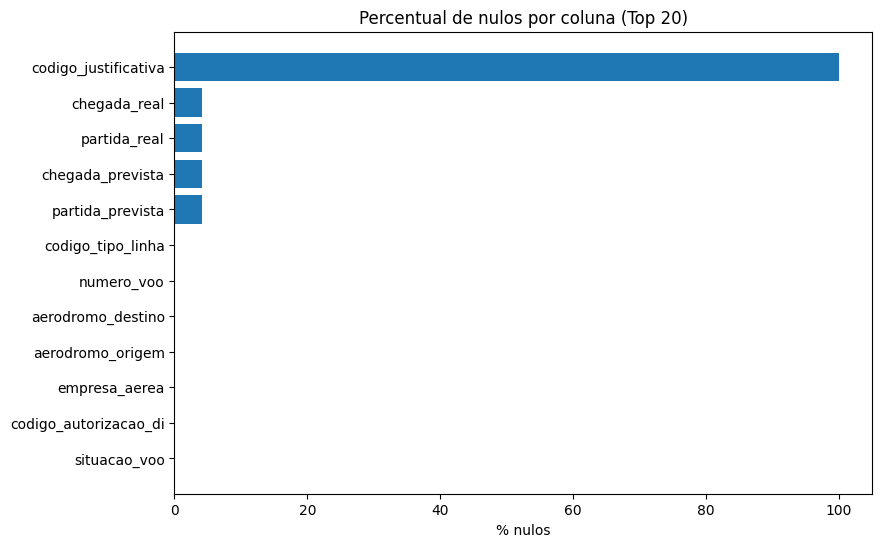

Numéricas plotadas: ['codigo_justificativa']
Categóricas plotadas: ['situacao_voo', 'codigo_tipo_linha', 'codigo_autorizacao_di', 'empresa_aerea', 'aerodromo_origem', 'aerodromo_destino']


c:\Users\helen\OneDrive\Área de Trabalho\OnFlight\Projeto OnFlight\Hackaton\Hackaton\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


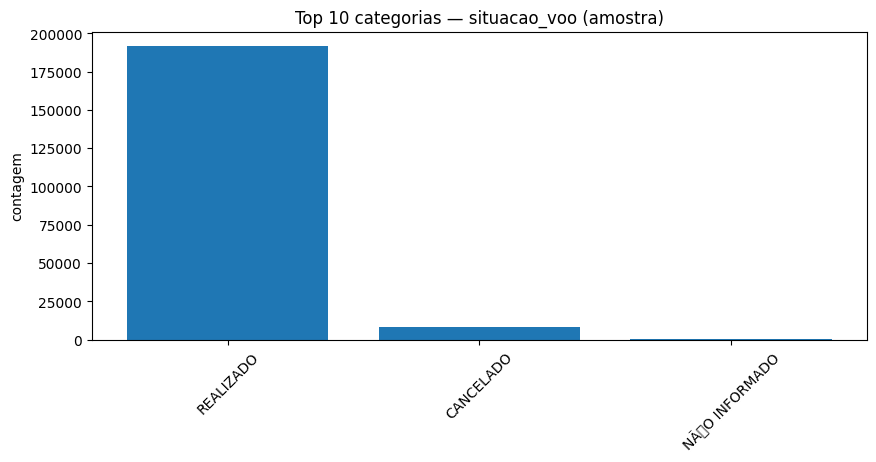

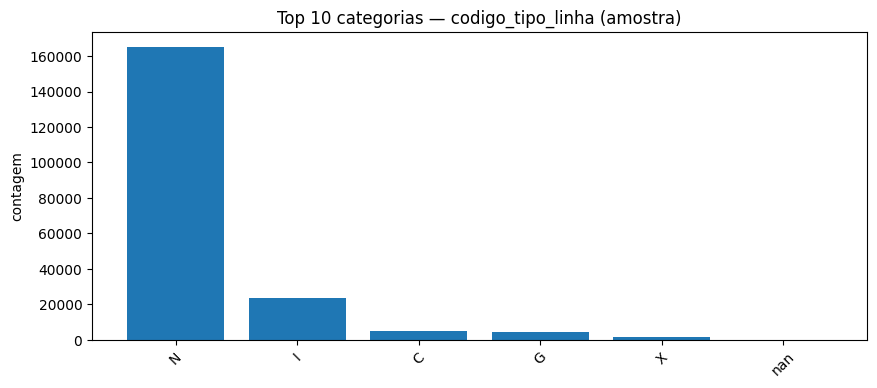

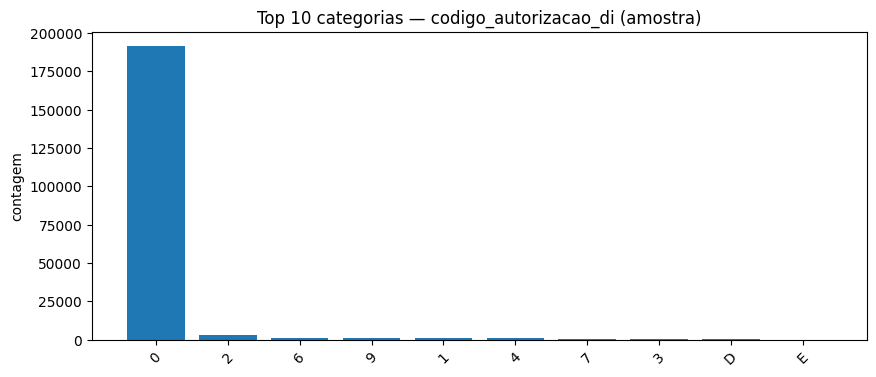

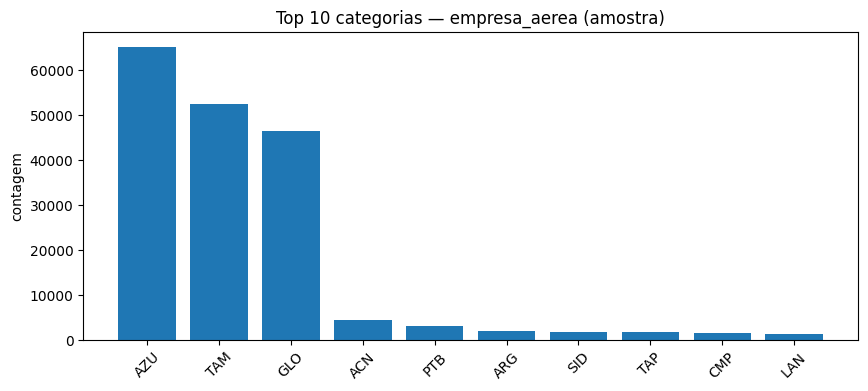

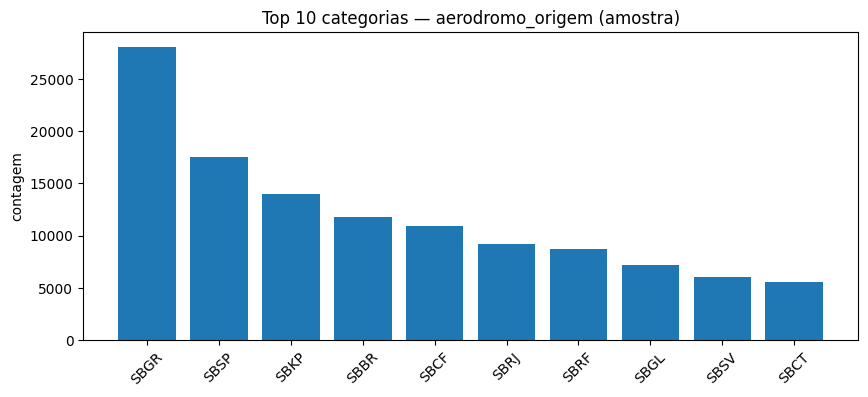

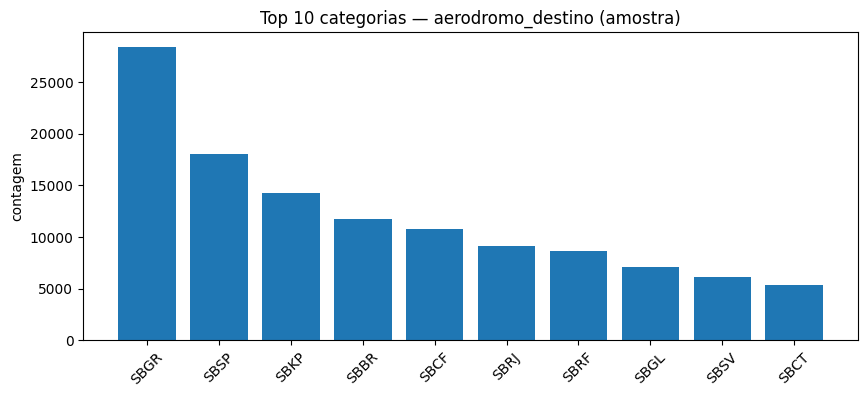

In [4]:
summary = scr.eda_viz(df, target=None)

In [5]:
df_flags = scr.criar_flags_qualidade_basicas(df)

df_flags[[
    "flag_partida_prevista_ausente",
    "flag_partida_real_ausente",
    "flag_data_fora_periodo"
]].mean()

flag_partida_prevista_ausente    0.041119
flag_partida_real_ausente        0.042030
flag_data_fora_periodo           0.000000
dtype: float64

In [6]:
df_model = scr.criar_target_atrasado(df_flags, limite_min=15)

df_model[scr.TARGET_COL].value_counts(normalize=True)
df_model.shape

(3644100, 17)

In [7]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644100 entries, 0 to 3968417
Data columns (total 17 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   empresa_aerea                  object        
 1   numero_voo                     object        
 2   codigo_autorizacao_di          object        
 3   codigo_tipo_linha              object        
 4   aerodromo_origem               object        
 5   aerodromo_destino              object        
 6   partida_prevista               datetime64[ns]
 7   partida_real                   datetime64[ns]
 8   chegada_prevista               datetime64[ns]
 9   chegada_real                   datetime64[ns]
 10  situacao_voo                   object        
 11  codigo_justificativa           float64       
 12  flag_partida_prevista_ausente  bool          
 13  flag_partida_real_ausente      bool          
 14  flag_data_fora_periodo         bool          
 15  atraso_partida_min  

In [8]:
# Definição dos conjuntos de treino, validação e teste

time_col = "partida_prevista"
df_train, df_val, df_test = scr.criar_split_temporal_train_val_test(
    df_model,
    time_col=time_col,
    train_size=0.7,
    val_size=0.1
)

# Checagem dos conjuntos
print("Formato do conjunto de treino: ", df_train.shape)
print("Periodo dos dados de treino: ", df_train[time_col].min(), "→", df_train[time_col].max())
print("-"*80, "\n")
print("Formato do conjunto de validação: ", df_val.shape)
print("Periodo do dados de valiação: ", df_val[time_col].min(), "→", df_val[time_col].max())
print("-"*80, "\n")
print("Formato do conjunto de teste: ", df_test.shape)
print("Periodo do dados de teste: ", df_test[time_col].min(), "→", df_test[time_col].max())

Formato do conjunto de treino:  (2550870, 17)
Periodo dos dados de treino:  2021-01-01 00:05:00 → 2024-04-16 10:20:00
-------------------------------------------------------------------------------- 

Formato do conjunto de validação:  (364409, 17)
Periodo do dados de valiação:  2024-04-16 10:25:00 → 2024-09-09 08:00:00
-------------------------------------------------------------------------------- 

Formato do conjunto de teste:  (728821, 17)
Periodo do dados de teste:  2024-09-09 08:00:00 → 2025-07-01 07:10:00


In [9]:
# Definição das colunas que irão para o modelo
cfg = scr.FeatureConfig(
    numeric_features=[
        # criadas pelo função DatasFeaturesTransformer
        "hora_dia",
        "dia_semana",
        "mes_ano",
        "fim_de_semana",
        "alta_temporada",
        "hora_sin",
        "hora_cos",
        "is_hub",

        # criadas pelo pela função MediaAtrasoTransformer
        "media_atraso_empresa",
        "media_atraso_origem",
        "media_atraso_destino",
    ],
    categorical_features=[
        # originais
        "empresa_aerea",
        "codigo_tipo_linha",
        "aerodromo_origem",
        "aerodromo_destino",
        "situacao_voo",

        # criada pela função DatasFeaturesTransformer
        "periodo_dia",
    ],
)

In [10]:
# simula só o FE pra ver quais colunas existem após criar features
Xtmp = df_train.drop(columns=[scr.TARGET_COL]).copy()
Xfe = scr.Pipeline(steps=[
    ("datas", scr.DatasFeaturesTransformer(col_dt="partida_prevista", col_atraso="atraso_partida_min")),
    ("ultimate", scr.UltimateFeatureEngineer()),
    ("medias", scr.MediaAtrasoTransformer(col_atraso="atraso_partida_min")),
]).fit_transform(Xtmp)

missing = [c for c in cfg.numeric_features + cfg.categorical_features if c not in Xfe.columns]
print("Faltando:", missing)

Faltando: []


In [11]:
# Definição do exemplos da classe minoritária 
y_train = df_train[scr.TARGET_COL].astype(int)
counts = y_train.value_counts()
print(counts)
n_min = counts.min()
print("n_min (minoria no treino) =", n_min)
k_auto = max(1, min(5, n_min - 1))
print("k_neighbors recomendado =", k_auto)

atrasado
0    2151215
1     399655
Name: count, dtype: int64
n_min (minoria no treino) = 399655
k_neighbors recomendado = 5


In [12]:
# Checagem para ver o numero de colunas
X = df_train.drop(columns=[scr.TARGET_COL]).copy()

fe = scr.Pipeline(steps=[
    ("datas", scr.DatasFeaturesTransformer(col_dt="partida_prevista", col_atraso="atraso_partida_min")),
    ("ultimate", scr.UltimateFeatureEngineer()),
    ("medias", scr.MediaAtrasoTransformer(col_atraso="atraso_partida_min")),
])

X_fe = fe.fit_transform(X)

pre = scr.montar_preprocessador(cfg)
pre.fit(X_fe)

n_out = pre.transform(X_fe.iloc[:1000]).shape[1]
print("Nº colunas após processamento:", n_out)

Nº colunas após processamento: 555


In [14]:
# Treinamento dos Modelos
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver="saga", class_weight="balanced", tol=1e-3),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, class_weight="balanced_subsample", random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(scale_pos_weight=4, tree_method="hist", n_jobs=-1, random_state=42),
    "LightGBM": LGBMClassifier(class_weight="balanced", verbose=-1, n_jobs=-1)
}

resultados = []
cms = {}
pipes = {}  
tempos = {}

for nome, modelo in modelos.items():
    t0 = perf_counter()
    out = scr.treinar_classificador(
        df_train=df_train,
        df_test=df_test,
        cfg=cfg,
        model=modelo,
        target=scr.TARGET_COL,
        use_smote=False
    )

    # performance de tempo
    tempos[nome] = perf_counter() - t0
    print(f"{nome} levou {tempos[nome]/60:.2f} min para treinamento")

    # guarda o pipeline
    pipes[nome] = out["pipeline"]

    # extrai métricas e CM
    met = scr.extrair_metricas(out, positive_label="1")
    cms[nome] = met.pop("cm")
    resultados.append({"Modelo": nome, **met})

df_resultados = (
    pd.DataFrame(resultados)
    .sort_values(by="f1_pos", ascending=False)
    .reset_index(drop=True)
)

df_resultados

Logistic Regression levou 36.25 min para treinamento
Random Forest levou 9.08 min para treinamento
XGBoost levou 1.07 min para treinamento
LightGBM levou 0.36 min para treinamento


,Modelo,accuracy,precision_pos,recall_pos,f1_pos,support_pos,f1_macro,f1_weighted,roc_auc
0,LightGBM,0.649623,0.269162,0.568279,0.365302,129315.0,0.561661,0.688341,0.668412
1,XGBoost,0.734213,0.308183,0.400039,0.348154,129315.0,0.590615,0.747035,0.670007
2,Logistic Regression,0.639453,0.255733,0.540247,0.347142,129315.0,0.549051,0.679310,0.644045
3,Random Forest,0.636284,0.253345,0.539195,0.344721,129315.0,0.546502,0.676679,0.645806


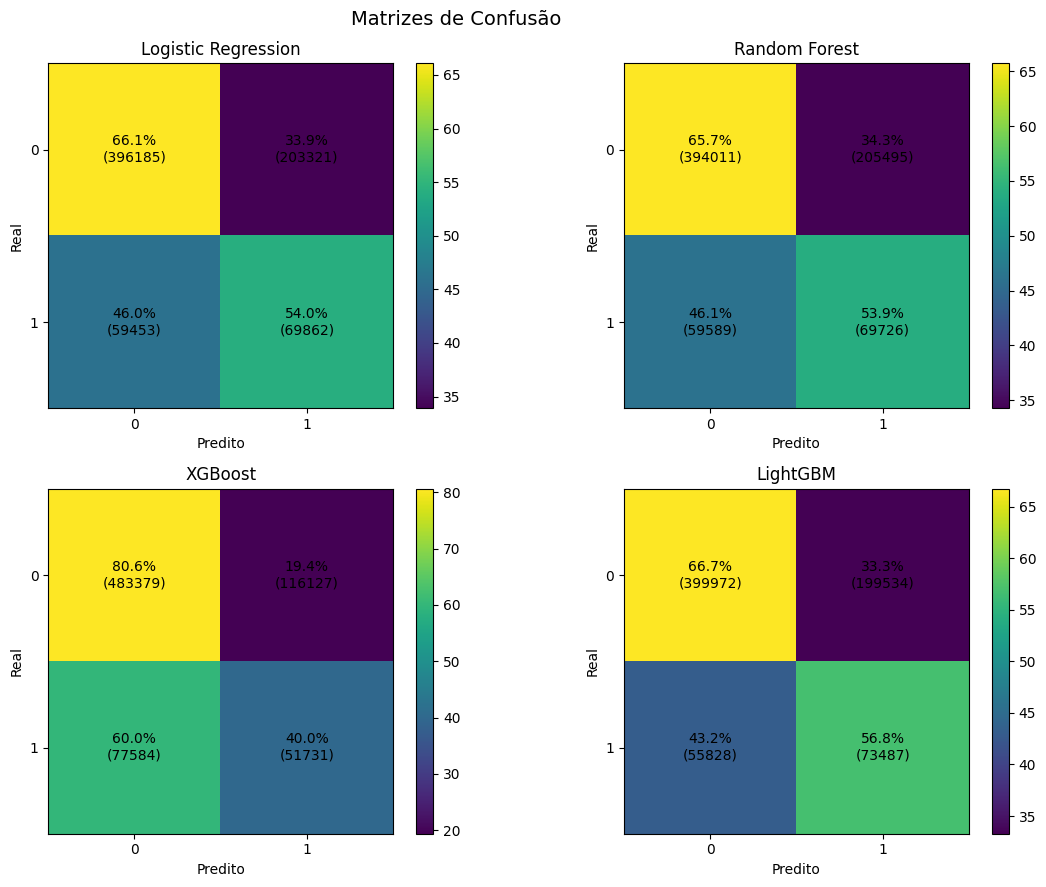

In [15]:
scr.plot_cm_percent_2x2(cms, title="Matrizes de Confusão")

In [16]:
df_resultados.sort_values("roc_auc", ascending=False)[["Modelo","roc_auc","f1_pos","recall_pos","precision_pos"]].head(2)

,Modelo,roc_auc,f1_pos,recall_pos,precision_pos
1,XGBoost,0.670007,0.348154,0.400039,0.308183
0,LightGBM,0.668412,0.365302,0.568279,0.269162


In [ ]:
melhor_modelo = df_resultados.loc[0, "Modelo"]
melhor_pipe = pipes[melhor_modelo]
print("Melhor Modelo:", melhor_modelo)

In [ ]:
# Constroi o caminho para salvar o cabelo
SCRIPTS_PATH = Path(SCRIPTS_PATH)  
model_filename = f"flight_delay_pipeline__best_{melhor_modelo}.pkl"
MODEL_PATH = SCRIPTS_PATH / model_filename

# Salva modelo
scr.salvar_pickle(melhor_pipe, str(MODEL_PATH))
print("Modelo salvo em:", MODEL_PATH)

In [ ]:
# Escrever a API
NOTEBOOK_DIR = Path.cwd()                 
SEMANA_DIR = NOTEBOOK_DIR.parent          
SCRIPTS_DIR = SEMANA_DIR / "scripts"      

# Garante que a pasta scripts existe
SCRIPTS_DIR.mkdir(parents=True, exist_ok=True)

# Conteúdo do arquivo da API
code = """import flight_delay_pipeline as scr
from pathlib import Path

BASE_DIR = Path(__file__).resolve().parent
MODEL_PATH = BASE_DIR / "flightontime_pipeline.pkl"

app = scr.criar_app_fastapi(str(MODEL_PATH))
"""

# Caminho final do arquivo
api_file = SCRIPTS_DIR / "api_app.py"

# Escrita do arquivo
api_file.write_text(code, encoding="utf-8")

print(f"Arquivo api_app.py criado em: {api_file}")